# Machine Learning for disease diagnosis using omics data

### Discussion Agenda 3rd & 9th Aug 21:

1. Summary of progress since Juy 19th discussion:

    - In our past 2 discussions, two errors in the experimental design were identified:
        1. Hyper parameter optimisation was done independently in a single train test split, and then those values of the hyper parameters were fixed and applied to multiple splits. The issue is leakage from train to test.
        2. Features importances were calculated by taking the average of the feature importances across all iterations of the train/test split 
    
    - Hyper-parameter optimisation within the 'inner loop' of the nested cross validation
        - All models have been rebuilt so that hyper parameter optimisation takes place independently for every iteration of the train/ test split
        - The approach is a nested cross validation
            Outer loop is a repeated KFold cross validation with 3 folds, so 66/33 train/ test split.
            Inner loop uses leave one out cross validation to score set of hyper parameters
            Set up the scoring so that the prediction of the validation example is stored, and so any score can be calculated over the 42 cross validation loops (rather than use the built in cross-validation that scores every fold, then averages across the folds). Am using accuracy for the cross validation, but could use any score.
        - In the case of SVM, recursive feature elimination is used to reduce the number of features, this is run for every value of the hyper parameter C, within the cross validation
        - In order to make the run time of the svm manageable, given the time taken by the recursive feature elimination proceedure, the number of features in the train set is initially recued from the 48,000 to 150, using a 'select K best' proceedure, based on mutual information gain. Clearly this is crude, and is a limitation of the methodology.
                
    - Feature importances / gene identification
        - Feature importance identification achieved by retraining the final model on the entire dataset, and extracting feature importances - either based on the coefficients (log regression and linear svm) or the feature importances method for the tree based alogorithms (random forest and xgboost)
        - The top features are inconsistent between the models - see charts below. This is a point for discussion.
 
    
2. Results (02/08/21)

a) using 9 iterations of the train/test split, with all features


| ML Method             | Recall    | Precision | AUC  |
| :-                    | :-:       | :-:       |:-:   |
| Logistic Reg          | 0.94      | 0.92      | 0.98 |
| SVM - grid seach      | 0.93      | 0.93      | 0.98 |
| SVM - baysian opt     | 0.93      | 0.95      | 0.97 |
| Random Forest         | 0.92      | 0.93      | 0.99 |
| XGBoost               | 0.x     | 0.x      | 0.x |


b) using 9 iterations of the train/test split, excluding patient Inf_075, the suspected viral sepsis case


| ML Method             | Recall    | Precision | AUC  |
| :-                    | :-:       | :-:       |:-:   |
| Logistic Reg          | 0.99      | 0.94      | 1.0  |
| SVM - grid seach      | 0.97      | 0.99      | 1.0  |
| SVM - baysian opt     | 0.95      | 0.99      | 1.0  |
| Random Forest         | 0.97      | 0.93      | 0.99 |
| XGBoost               | 0.x      | 0.x      | 0.x |


The top 20 selected genes from the Logistic Regression model identifying the positive class (inf.):


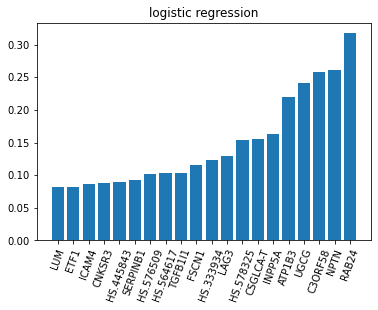

In [1003]:
print('The top 20 selected genes from the Logistic Regression model identifying the positive class (inf.):')

plot_genes(selected_gene_lr_final[-21:-1], model='logistic regression')

The selected genes using SVM - approach 1, grid search over hyper params:


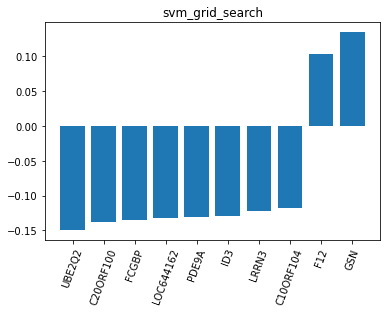

In [981]:
print('The selected genes using SVM - approach 1, grid search over hyper params:')

plot_genes(selected_gene_svm_gs_final, model='svm_grid_search')

The selected genes using SVM - approach 2, Baysian optimisation over hyper params:


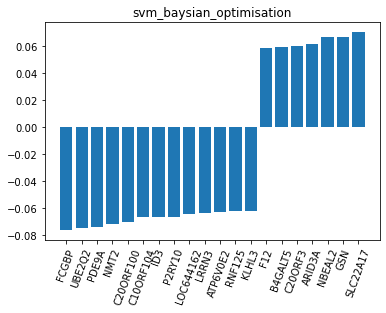

In [982]:
print('The selected genes using SVM - approach 2, Baysian optimisation over hyper params:')

plot_genes(selected_gene_svm_b_final, model='svm_baysian_optimisation')

The top 20 selected genes from the Random Forest Classifier:


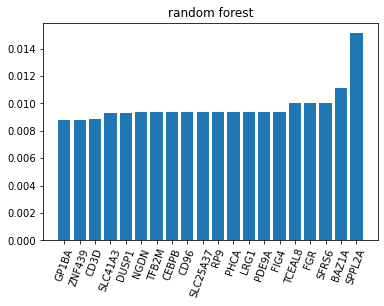

In [996]:
print('The top 20 selected genes from the Random Forest Classifier:')

plot_genes(selected_gene_rf_final[-21:-1], model='random forest')


3. Potential next steps:

- Ask for feedback from Project Sepsis team on the selected genes
- SVM - try alternative to Recursive feature elimination, where features are eliminated based on coefiients, and use a different function - sequential feature selection, again with a backward search, but using BIC probabalistic methods to score each model to determine the optimum balance of number of features and performance. Would do without cross validation, and just score on the train set.
- Clean & Integrate clinical data - requires some pre-processing
- Additional Hyper parameter tuning and optimisation of Random Forest and XGBoost
- Experiment with deep learning based feature selection methods from lit search

  
4. Specific questions for discussion:

- Discussion of approaches to feature selection - e.g. filter based methods looking at the univariate correlation with the target variable, relative deviation of a feature from the mean, vs. wrapper methods that fit a model with varying numbers of features.

- How important is it to obtain a consistent set of features between the models? What is the right size of feature set to select - e.g. the original paper selects 54 genes. Is 50 a good benchmark? Or should we make this part of the optimisation of the models - possible, but only if we start with say 500-1,000 for the optimisation.

- Feedback on next steps and validity of the results in general

### Aims and Objectives

The aim of this project is to develop a machine learning system capable of diagnosing neo-natal sepsis based on genomic and clinical patient data. The system will successfully perform a binary classification of examples as either infected (i.e. have sepsis) and not infected. Initial objectives:
- Review existing literature and techniques for disease diagnosis using machine learning with omics data
- Test and compare the effectiveness of alternative strategies for dimensionality reduction - the dataset contains 63 samples and over 48,000 features. Candidate techniques include:
    - Univariate statistical tests on each feature - e.g. mutual information on each individual features, and selecting k best features based on scores.
    - L1 regularisation to downweight irrelevant features in linear model (e.g. in logistic regression/ linear svm)
    - Recursive feature elimination (e.g. in SVM, Tree based models)
    - Sequential forward greedy search, adding additional features each iteration
- Test alternative classifiers and compare results, using the above feature selection approaches. The choice of classifiers will be directed by the high dimensionality, low sample size (HDLSS) nature of this problem. Candidate techniques include. Success determined by models that have good performance in the classification task based on a consistent set of features over multiple iterations.
    - Logistic regression - L1 regularised as a feature selection approach
    - Support Vector Machines, with recursive feature elimination
    - Ensemble decision tree based methods - Random Forest, XGBoost, again with recursive feature elimination
    - Deep Neural Network based methods to capture non-linear relationships that are designed to work with with high dimenional, low sample size data - combined dimentionality reduction and classification techniques such as FsNet and Deep Neural Pursuit (see lit review 5 and 6)
- Identify the specific biomarkers (genes) and clinical data points that show the greatest importance in successfully discrimnating sepsis consistently across models and feature selection approaches
- Implement and evaluate the performance of models based on the specific biomarkers identified

### Background / Literature Review (at 16/6/21)

The following papers provide relevant starting points for investigation:

1. [Gene selection for cancer classification using SVMs, Guyon et al. 2001](https://link.springer.com/article/10.1023/A:1012487302797)
2. [Applications of Support Vector Machine (SVM) Learning in Cancer Genomics, Huang et al. 2018](https://pubmed.ncbi.nlm.nih.gov/29275361)
3. [Machine learning and complex biological data, Jackson et al. 2019](https://link.springer.com/article/10.1186/s13059-019-1689-0)
4. [Machine learning algorithm validation with a limited sample size, Vabalas et al. 2019](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0224365)
5. [FsNet: Feature Selection Network on High-dimensional Biological Data, Singh et al. 2020](https://arxiv.org/abs/2001.08322)
6. [Deep Neural Networks for High Dimension, Low Sample Size Data, Liu et al. 2017](https://www.semanticscholar.org/paper/Deep-Neural-Networks-for-High-Dimension%2C-Low-Sample-Liu-Wei/76f755fed7bf1cea8dad35c16bf518eab158c13e?p2df)

### Summary of Methodology and Initial Results

This file and raw data in github repo here: https://github.com/parkyed/sepsis_ml_omics_msc

**1. Data pre-processing (genomic data only to date)**
- Neonatal_dataset saved in CSV format.
- Data de-duplicated based on the feature 'Probe_Id' based on advice from project sepsis team. 1 duplicate row identified and eliminated
- Standardisation- confirmed that there are no NaN values, however built functionality to replace NaN values with mean for the feature. Data then standardised (z-scored) to enable use of regression coefficients to determine feature importance, application of L1 regularlisation and use of distance based techniques such as SVM. (Implication is that NaN values standardised to zero).
- Clinical data TBD

**2. Train/val/test approach
- Given the very low number of examples - 63 examples, implemented a 'nested cross validation strategy' to enable repeating experiments over multiple train / test splits, and then averaging the scores across multiple splits
- Outer cross validation loop uses a Repeated K fold, splitting data into 3 folds - i.e. 66/33 split train / test. This can be run multiple times, e.g. 3 times, to give 9 different train / test splits of the data, ensuring that every examples is both in train and test every three iterations. Chose 66/33 to ensure sufficient examples in test to validate the results. Decided against a separate validation set initially given low sample size.
- Inner cross validation loop used to train the model and implement feature selection proceedures. Cross validation uses leave one out cross validation to maximise the use of the data.

**2. Logistic regression**
- Logistic regression chosen as a baseline. Method used by John in sepsis vs. TB poster.
- Logistic regression classifier with L1 regularisation. C determined using Baysian Optimisation with Gaussian Processes, calling function 15 times to ensure convergence of hyper parameter.

**3. SVM with recursive feature elimination**
- SVM with recursive feature elimination has been demonstrated as an effective approach to classification with omics data (see ref 1., Guyon et al. 2001 above)
- Performing RFE on all 48,000 features computationally expensive, therefore initially performed feature selection to reduce to 150 features based on univariate tests using mutual information gain (entropy) and retaining the highest scoring features.
- Recursive feature elimination (RFE) used to select best features.
- Built two separate models - one uses grid search over both the hyper parameter C, and the number of features to select. The other fixes the number of features at 20, and used Baysian optimisation to determine C.

**4. Random Forest**
- Random forest classifier optimised using randomised search to optimise for number of estimators vs. number of randomly selected features across each estimator initially.
- Grid search top optimise the number of estimators and max features to select.

**5. XGBoost**
- XGBoost trained on full dataset using the 'binary:logistic' objective function, which uses logloss to calculate the error.
- Grid search over key hyper parameters.

**6. Potential Next Steps**

- SVM - try alternative to Recursive feature elimination, where features are eliminated based on coefiients, and use a different function - sequential feature selection, again with a backward search, but using BIC probabalistic methods to score each model to determine the optimum balance of number of features and performance. Would do without cross validation, and just score on the train set.
- Determine whether calibration required before ROC plot for SVM / RF / XGBoost
- Clean & Integrate clinical data - requires some pre-processing
- Additional Hyper parameter tuning and optimisation of Random Forest and XGBoost
- Experiment with deep learning based feature selection methods from lit search

**7. Issues / Limitations of the work to highlight**

- Artificially balanced classes - find additional control examples to make it more realistic - e.g. 99/1%
- Sepsis / not sepsis may be too simplistic, e.g. viral vs. bacterial sepsis not taken into account

# Code:

In [2]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import KFold, RepeatedKFold
import warnings
from joblib import dump, load
from pickle import dump, load
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.")
#np.random.seed(1)


In [3]:
os.getcwd()

'/Users/Ed/Documents/GitHub/sepsis_ml_omics_msc/notebook_archive'

### Data Import and Reformatting

In [5]:
# import and check data

raw_data = pd.read_csv('/Users/Ed/Documents/GitHub/sepsis_ml_omics_msc/genomic_data.csv')
print('The number of columns is:  '+str(len(raw_data.columns)))
print('The number of row is:  '+str(len(raw_data)))

The number of columns is:  93
The number of row is:  48804


In [6]:
# Eliminate duplicate genes. Testing on various columns, NaN values excluded before looking for duplicates.

dup_column = ['NuID', 'Search_Key', 'ILMN_Gene', 'RefSeq_ID', 'Entrez_Gene_ID', 'Probe_Id']
for column in dup_column:
    data = raw_data.dropna(subset=[column])
    dup_list = []
    for index, value in data.duplicated(subset=[column]).items():
        if value == True:
            dup_list.append(index)
    print(f"# duplicate rows based on {column}:   "+str(len(dup_list)))

# duplicate rows based on NuID:   0
# duplicate rows based on Search_Key:   4671
# duplicate rows based on ILMN_Gene:   11000
# duplicate rows based on RefSeq_ID:   5742
# duplicate rows based on Entrez_Gene_ID:   10897
# duplicate rows based on Probe_Id:   1


In [7]:
# reformat data, drop duplicates, transpose, index on probe_id, drop columns with all NaN, drop Fold change

gene_df = raw_data.iloc[:, 0:29]
df = raw_data.iloc[:, np.r_[14, 29:93]].drop_duplicates(subset=['Probe_Id'])
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.drop(['Fold change'], axis=0)
df = df.dropna(axis=1, how='all')

labels = []
for item in df.index:
    if 'Con' in item:
        labels.append(0)
    else:
        labels.append(1)
labels = np.asarray(labels)

print('Features:  '+str(len(df.columns)))
print('Examples:  '+str(len(df)))
print('Missing values:   '+str(df.isnull().sum().sum()))
df.head()

Features:  48802
Examples:  63
Missing values:   0


,ILMN_2227757,ILMN_1683690,ILMN_1710146,ILMN_1822171,ILMN_1748473,ILMN_1822843,ILMN_1710170,ILMN_1704497,ILMN_1847638,ILMN_1772260,...,ILMN_1712859,ILMN_1747129,ILMN_1813344,ILMN_2292576,ILMN_1793445,ILMN_2065273,ILMN_1800873,ILMN_1666642,ILMN_1908209,ILMN_1670343
Con_001,7.0713,7.0252,7.0713,7.0713,12.8555,7.0395,7.0252,7.0252,6.9692,7.1443,...,6.9278,7.0713,7.6728,7.0545,7.0103,7.0252,7.2258,7.3808,7.2626,6.9828
Con_017,7.0033,7.0436,7.0832,7.1232,12.5604,7.1232,7.0301,7.1486,6.9203,7.1865,...,7.0436,7.0164,8.1798,6.9896,6.9896,7.0963,7.0577,6.9492,7.0164,7.0301
Con_021,7.0907,7.0323,7.097,7.0824,12.5437,7.0583,7.0739,6.9975,6.9975,7.0405,...,7.097,7.0158,7.8981,7.0158,7.1521,7.0655,7.0824,6.9975,7.097,6.9892
Con_022b,7.0327,7.024,7.0419,7.024,12.0483,7.0766,7.0598,7.1015,6.9954,7.0055,...,7.1564,7.167,7.9036,6.9031,7.0598,6.9863,7.1625,7.1378,7.024,7.0327
Con_028,7.0057,6.9538,7.0308,7.0831,12.6549,6.9538,6.9538,7.1371,7.1512,7.264,...,7.0577,7.0057,8.2019,7.0308,7.0702,6.9799,7.0963,7.1512,7.2064,7.0186


In [25]:
bool_series_zeros = (df == 0).all(axis=0)
print('The number of columns with all zeros is:   '+str(sum(bool_series_zeros)))

The number of columns with all zeros is:   0


In [10]:
counter = 0
for item in a_series:
    if item == False:
        counter += 1
counter

0

In [908]:
# create copy of the data without patient Inf_075

df_no75 = df.drop(['Inf075'], axis=0)

# re-create labels
labels_no75 = []
for item in df.index:
    if item == 'Inf075':
        continue
    if 'Con' in item:
        labels_no75.append(0)
    else:
        labels_no75.append(1)
labels_no75 = np.asarray(labels_no75)
len(labels_no75)

# check it is correct
#list(zip(df_no75.index, labels_no75))
df_no75.shape

(62, 48802)

### Pre-Processing

1. **Standardisation** - Data standardised (i.e. z-scored) for the following reasons:
- L1 regularisation penalties in logistic regressions assumes data centred at zero and on the same scale
- Distance based ML models such as SVM require and assume standardised data, otherwise variables on larger scales disproportionally impact the model
- Am using the output coeffiecients from logistic regression as a crude measure of feature importance, and so in order to compare coefficients as a measure of relative importance, variables must be standardised

background - https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

2. **Train, test, split:** 66% train / 33% test

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


In [909]:
# standardise by imputing NaN values and using standard scale - z-scoring
# note - given imputer not necessary, could move standard scaler into the pipeline for each model

def standardise(examples):
    imputer = SimpleImputer(strategy='mean')
    examples_imputed = imputer.fit_transform(examples)
    scaler = StandardScaler()
    examples_scaled = scaler.fit_transform(examples_imputed)
    return examples_scaled

X_df = standardise(df)
X_df = pd.DataFrame(X_df, columns=df.columns, index=df.index)
print(X_df.shape)

# dataset excluding patient 75
X_df_no75 = standardise(df_no75)
X_df_no75 = pd.DataFrame(X_df_no75, columns=df_no75.columns, index=df_no75.index)
print(X_df_no75.shape)

# Reduced dataset for code testing
X_df_red = X_df.iloc[:, 0:200]
print(X_df_red.shape)

(63, 48802)
(62, 48802)
(63, 200)


### Functions for model analysis

In [910]:
def score_model(y_pred_classes, y_pred_probabilities, y_true_classes):
    accuracy = round(accuracy_score(y_true_classes, y_pred_classes),2)
    recall = round(recall_score(y_true_classes, y_pred_classes),2)
    precision = round(precision_score(y_true_classes, y_pred_classes),2) 
    auc = round(roc_auc_score(y_true_classes, y_pred_probabilities[:, 1]),2)
    return accuracy, recall, precision, auc

def mis_class_points(X_test, y_pred_classes, y_true_classes):
    mis_classified = {}
    for row_index, (examples, prediction, label) in enumerate(zip (X_test, y_pred_classes, y_true_classes)):
        if prediction == label:
            continue
        if prediction == 0 and label == 1:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fn'
        elif prediction == 1 and label == 0:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fp'
    return mis_classified  

def plot_auc_cm(X_test, y_pred_classes, y_pred_probabilities, y_true_classes):
    build_roc_auc(y_pred_probabilities, y_true_classes)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot(colorbar=False)

In [911]:
# function for building the ROC curve
# Code credit: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

def build_roc_auc(y_preds, y_test): #model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - an sklearn instantiated model
    X_train - the training data
    y_train - the training response values
    X_test - the test data
    y_test - the test response values
    
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    
    #y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic plot')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))

In [912]:
# Function to identify genes that differentiate sepsis, based on model coefficients / feature importances
# function to plot model coefficients for selected genes


# CHECK THIS IS STILL WORKING WITH SELECT K BEST!!

from matplotlib import pyplot

def identify_genes(df, gene_df, selected_features):
    gene_codes = df.columns
    gene_coefs = list(zip(gene_codes, selected_features))
    selected_genes = []
    for gene in gene_coefs:
        if gene[1] != 0:
            selected_genes.append(gene)
    selected_genes_sorted = sorted(selected_genes, key = lambda x: x[1])
    sel_gene_codes = [ i for i, j in selected_genes_sorted]
    sel_gene_df = gene_df[gene_df['Probe_Id'].isin(sel_gene_codes)].iloc[:, np.r_[14, 5]]
    return selected_genes_sorted, sel_gene_df

def plot_genes(features_sorted, model):
    pyplot.bar(range(len(features_sorted)), [val[1] for val in features_sorted])
    pyplot.xticks(range(len(features_sorted)), [val[0] for val in features_sorted])
    plt.title(model)
    pyplot.xticks(rotation=70)


### Classifier 1: Logistic Regression

- L1 regularised logistic regression. L1 used given we know that a large number of feature are irrelevant, hence L1 / Lasso regularisation acts as form of feature selection. L1 required the liblinear solver.
- L1 - Lasso - regularisation is an embedded feature selection method, therefore no additional feature selection implemented.
- Discussion of FS methods - https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/
- Nested cross validation used given the low sample size, and potential high variance in the output data
- code credit: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
- Source / ref: avoiding common pitfalls in machine learning omic data science paper
- Performed with Leave One Out cross-validation - i.e. n folds - on the regularisation parameter C. Given small samples size, LOO provides the least biased model, the most accurate estimate of model performance, as every training example is used as a validation set.
https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
- Had previously tried 5-fold cross validation - but loo improved the performance. Mention, and explain why.
- Ensemble model averaging - built functions to average across multiple models. code credit - https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

In [915]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut

# ASSUME THAT NOT GOING TO USE THIS, AS USING BAYSIAN SEARCH INSTEAD

def nested_cv_lr_gs(df, labels, n_repeats):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    selected_features_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # define cross validation approach
        cv_inner = LeaveOneOut()

        # define hyper parameter search space to optimise
        search_space = 20

        # define the model / search
        search = LogisticRegressionCV(Cs=search_space,
                                      penalty='l1',
                                      solver="liblinear",
                                      cv=cv_inner,
                                      scoring='accuracy',
                                      refit=True)

        # fit the model
        search.fit(X_train, y_train)

        # save the best performing value of hyper parameter C
        best_parameter = search.C_
        print(best_parameter)

        # retrain the model with fixed value of C
        model = LogisticRegression(C=best_parameter[0],
                                      penalty='l1',
                                      solver="liblinear")
        model.fit(X_train, y_train)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)
        selected_features = model.coef_
        print(selected_features)
        
        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        selected_features_list.append(selected_features)
        mis_classified_list.append(mis_classified)
    
    return scores_list, best_parameters_list, selected_features_list, mis_classified_list

# run nested cross validation on test data set
# scores_lr, best_parameters_lr, selected_features_lr, mis_classified_lr = nested_cv_lr(X_df_red, labels, n_repeats)

# run nested cross validation on full data set
#scores_lr, best_parameters_lr, selected_features_lr, mis_classified_lr = nested_cv_lr(X_df,  labels, n_repeats)

# run nested cross validation without patient 75
#scores_lr_no75, best_parameters_lr_no75, selected_features_lr_no75, mis_classified_lr_no75 = nested_cv_lr(X_df_no75, 
#                                                                                                       labels_no75,
#                                                                                                       n_repeats)
# print results
#print('The results for logistic regression with all 63 examples:')
#print(scores_lr)
#print(best_parameters_lr)
#print(np.mean(np.asarray(scores_lr), axis=0))
#print(mis_classified_lr)

#print('The results for logistic regression without patient 75:')
#print(scores_lr_no75)
#print(best_parameters_lr_no75)
#print(np.mean(np.asarray(scores_lr_no75), axis=0))
#print(mis_classified_lr_no75)

### Hyper-parameter optimisation - Baysian optimisation with Gaussian Processes

- The grid search of the logistic regression hyper parameter C is time consuming and slow, potentially testing a large number of useless and poorly performing parameters. May also result in high variance of the outcome over multiple train/ test splits (reference literature)
- Using Baysian optimisation with Gaussian Processes as a more computationally efficient, and more rigerous process to determine the optimum value of C.
- Manually coded the inner cross validation loop - to be able to store the predictions for each fold, and then calculate a score for the value of C, using the set of y-hat and y-val across all 42 folds. Built in CV assumes larger samples sizes with say 5 fold, and calculates a score on each fold and averages - doesn't allow to do recall / precision given could have zero demoniators. 
- Logistic regression with lasso - an embedded feature selection reduces features from 48,000 down to 200-300 features. Good, but ideally want a model that performs equally well, but is able to identify the best 5-10 feature - i.e. stronger penalties in place for useless features. However want to use an approach that involves fitting models, and not filtering based on linear relationships with the output variable. E.g. not Kbest or filter methods, given problems of co-linearity (see slide deck). Therefore looking at SVM-RFE, and regularised tree based models. And SVM with SFS using BIC???
- code credit - https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
- code credit - https://scikit-optimize.github.io/stable/modules/generated/skopt.utils.use_named_args.html
- code credit - https://towardsdatascience.com/optimizing-hyperparameters-the-right-way-3c9cafc279cc
- ref: https://scikit-optimize.github.io/stable/modules/generated/skopt.optimizer.gp_minimize.html#skopt.optimizer.gp_minimize


In [916]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.plots import plot_convergence, plot_evaluations
import pickle
import warnings
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before")

def nested_cv_lr(df, labels, n_repeats):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    selected_features_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        model, best_parameter = train_lr_baysian(X_train, y_train)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)
        
        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        mis_classified_list.append(mis_classified)
    
    return scores_list, best_parameters_list, mis_classified_list

def train_lr_baysian(X_train, y_train):
    # define cross validation approach
    cv_inner = LeaveOneOut()

    # define hyper paramaeter search space
    hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
    search_space_lr = [hyper_p_c]

    # define the objective function to optimise over the hyper-parameter search space. Here we want to minimise 1- the 
    # accuracy score - balancing recall and precision in the model.
    @use_named_args(search_space_lr)
    def evaluate_model(**params):
        cv_inner = LeaveOneOut()
        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]         
        
            # define the model
            model = LogisticRegression(penalty='l1', solver="liblinear")
            model.set_params(**params)
            model.fit(X_train_inner, y_train_inner)

            y_val_pred = model.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)
            
        score = accuracy_score(y_val_classes, y_val_predictions)
        return 1.0 - score

    # perform optimization
    result = gp_minimize(evaluate_model, search_space_lr, n_calls=15)

    # save the best performing value of hyper parameter C
    best_parameter = result.x
    print('Best Parameters: %s' % (result.x))
    print('Best Score: %.3f' % (1.0 - result.fun))
    plot_convergence(result)

    # retrain the model with fixed value of C
    model = LogisticRegression(C=best_parameter[0],
                                  penalty='l1',
                                  solver="liblinear")
    model.fit(X_train, y_train)

    return model, best_parameter

Best Parameters: [1000.0]
Best Score: 0.976
Best Parameters: [339.8223355953632]
Best Score: 0.952
Best Parameters: [9.180595334830837]
Best Score: 0.976
Best Parameters: [386.31516393489386]
Best Score: 0.952
Best Parameters: [584.3178144651998]
Best Score: 0.976
Best Parameters: [0.3085850243413426]
Best Score: 1.000
Best Parameters: [0.07724932959028347]
Best Score: 0.952
Best Parameters: [12.57362143451262]
Best Score: 0.929
Best Parameters: [10.423250796190027]
Best Score: 1.000
Best Parameters: [0.9930754702267499]
Best Score: 0.976
Best Parameters: [1.6765840409042874]
Best Score: 1.000
Best Parameters: [1.3120874066806705]
Best Score: 1.000
Best Parameters: [0.2608776940972944]
Best Score: 1.000
Best Parameters: [18.540006361080852]
Best Score: 0.976
Best Parameters: [1.0133122392941403]
Best Score: 0.976
Best Parameters: [0.40888356288114064]
Best Score: 1.000
Best Parameters: [152.61734290321758]
Best Score: 0.976
Best Parameters: [22.182549296406687]
Best Score: 0.976


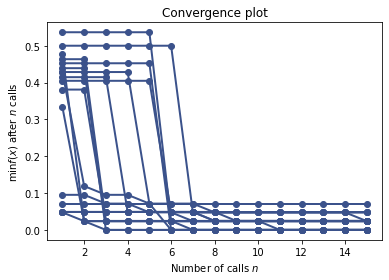

In [917]:
# run optimisations

# run nested cross validation on test data set
#scores_lr_red, best_parameters_lr_red, mis_classified_lr_red = nested_cv_lr(X_df_red, labels, 1)

# run nested cross validation on full data set
scores_lr, best_parameters_lr, mis_classified_lr = nested_cv_lr(X_df,  labels, 3)

# run nested cross validation without patient 75
scores_lr_no75, best_parameters_lr_no75, mis_classified_lr_no75 = nested_cv_lr(X_df_no75, labels_no75, 3)


In [918]:
# Print LR results

from matplotlib import pyplot

# print results
#print('The results for logistic regression test examples:')
#print(scores_lr_red)
#print(best_parameters_lr_red)
#print(np.mean(np.asarray(scores_lr_red), axis=0))
#print(mis_classified_lr_red)

#print('The results for logistic regression with all 63 examples:')
print(scores_lr)
print(best_parameters_lr)
print(np.mean(np.asarray(scores_lr), axis=0))
print(mis_classified_lr)

#print('The results for logistic regression without patient 75:')
print(scores_lr_no75)
print(best_parameters_lr_no75)
print(np.mean(np.asarray(scores_lr_no75), axis=0))
print(mis_classified_lr_no75)

#with open('lr_results.pkl', 'rb') as f:
#    a, b, c, d, e, f, g, h = pickle.load(f)

[(0.95, 1.0, 0.88, 1.0), (0.86, 0.9, 0.82, 0.97), (0.95, 0.91, 1.0, 1.0), (0.95, 1.0, 0.91, 1.0), (0.9, 1.0, 0.82, 1.0), (0.9, 0.78, 1.0, 0.91), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (0.9, 0.88, 0.88, 0.98)]
[[1000.0], [339.8223355953632], [9.180595334830837], [386.31516393489386], [584.3178144651998], [0.3085850243413426], [0.07724932959028347], [12.57362143451262], [10.423250796190027]]
[0.93444444 0.94111111 0.92333333 0.98444444]
[{'Con_206': 'fp'}, {'Con_079': 'fp', 'Con_165a': 'fp', 'Inf_149': 'fn'}, {'Inf075': 'fn'}, {'Con_165a': 'fp'}, {'Con_087a': 'fp', 'Con_206': 'fp'}, {'Inf075': 'fn', 'Inf_149': 'fn'}, {}, {}, {'Con_165a': 'fp', 'Inf075': 'fn'}]
[(0.95, 1.0, 0.89, 1.0), (0.95, 1.0, 0.91, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (0.95, 1.0, 0.93, 1.0), (0.9, 1.0, 0.82, 1.0), (0.95, 1.0, 0.88, 1.0), (0.95, 0.91, 1.0, 1.0)]
[[0.9930754702267499], [1.6765840409042874], [1.3120874066806705], [0.2608776940972944], [18.540006361080852], [1.0133

Best Parameters: [112.62820117102731]
Best Score: 0.968


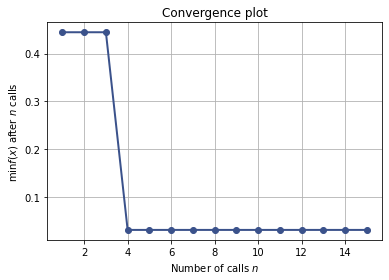

In [919]:
# train final model and determine features

# re-training the final model on the full dataset to identify the selected features    
# extract coefficients based on model type

final_lr, best_param = train_lr_baysian(X_df, labels)

In [999]:
# select features and match to common gene names

#selected_features_lr = final_lr.coef_
#lr_genes, lr_gene_df = identify_genes(X_df, gene_df, selected_features_lr[0])

# extract coefficients following RFE

selected_features_lr = final_lr.coef_
selected_gene_list_lr = list(zip(X_df.columns, selected_features_lr[0]))

selected_gene_codes_lr = []
selected_gene_coefficients_lr = []
for gene in selected_gene_list_lr:
    if gene[1] != 0:
        selected_gene_codes_lr.append(gene[0])
        selected_gene_coefficients_lr.append(gene[1])

# identify common gene codes
selected_gene_lr_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes_lr)].iloc[:, np.r_[14, 5]]
selected_gene_codes_common_lr = list(selected_gene_lr_df.iloc[:,1])

# zip features importances with common names

selected_gene_lr_final = list(zip(selected_gene_codes_common_lr, selected_gene_coefficients_lr))
selected_gene_lr_final = sorted(selected_gene_lr_final, key = lambda x: x[1])

The number of selected genes is:  336


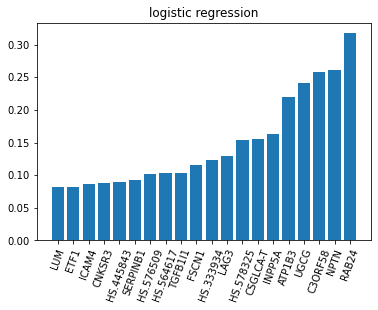

In [1002]:
print('The number of selected genes is:  '+str(len(selected_gene_lr_final)))
plot_genes(selected_gene_lr_final[-21:-1], model='logistic regression')

In [921]:
# saving down results of the model

with open('lr_results.pkl', 'wb') as f:
    pickle.dump([scores_lr, best_parameters_lr, mis_classified_lr, selected_features_lr,
                scores_lr_no75, best_parameters_lr_no75, mis_classified_lr_no75], f)

In [971]:
with open('lr_final_model.pkl', 'wb') as f:
    pickle.dump([final_lr, best_param], f)

### Classifier 2: SVM

1. Initial feature selection using kbest feature selection and mutual information gain
2. Further feature selection using recursive feature selection (RFE) to get down the the best performing set of features on linear svm

References:
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- important point - use pipeline so that the same train and validation sets are used for both the feature
- selection and the hyperparameter tuning, avoiding data leakage from train to val. Here not
- tuning hyper parameters, but want to do all the fit transforms in a chain, to use the nested CV loop

### SVM using grid search over C and number of features

In [922]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold
from numpy.random import uniform
import operator
from sklearn.pipeline import make_pipeline, Pipeline
from skopt.space import Categorical
import pickle

In [938]:
# create single train test split for testing

#X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_df, labels, test_size=0.33) #, random_state=1)

# function to implement univariate feature selection based on kbest, to n_features

def filter_features(X_train, y_train, X_test, n_features):
    fs=SelectKBest(mutual_info_classif, k=n_features).fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    gene_list = list(zip(X_train.columns, fs.get_support()))
    new_features = []
    for gene in gene_list:
        if gene[1] == True:
            new_features.append(gene[0])
    X_train = pd.DataFrame(X_train_fs, columns=new_features, index=X_train.index)
    X_test = pd.DataFrame(X_test_fs, columns=new_features, index=X_test.index)
    return X_train, X_test

def filter_features_final(X_train, y_train, n_features):
    fs=SelectKBest(mutual_info_classif, k=n_features).fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    gene_list = list(zip(X_train.columns, fs.get_support()))
    new_features = []
    for gene in gene_list:
        if gene[1] == True:
            new_features.append(gene[0])
    X_train = pd.DataFrame(X_train_fs, columns=new_features, index=X_train.index)
    return X_train, new_features

In [924]:
# support vector machine nested cross validation. The inner loop is a manual grid search over hyper parameters
# C and the number of features to select in the RFE

def nested_cv_svm(df, labels, n_repeats):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]
        
        # implement univariate feature selection
        X_train, X_test = filter_features(X_train, y_train, X_test, 150)

        # train and fit the model
        model, best_C, best_f = train_svm(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_C, best_f))
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, mis_classified_list


def train_svm(X_train, y_train):

    # define pipeline and perform search
    param_grid = {'C': [0.01, 0.1, 1.0, 10, 100], 'f': [5, 10, 20]}
    cv_inner = loocv

    cv_res= []

    for param in ParameterGrid(param_grid):

        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # define the rfe proceedure
            svc = SVC(kernel="linear", C=param['C'], probability=True)        
            rfe = RFE(estimator=svc, n_features_to_select=param['f'], step=10)
            pipe = Pipeline(steps=[('rfe', rfe),
                                   ('clf', svc)])
            pipe.fit(X_train_inner, y_train_inner)

            y_val_pred = pipe.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        print('Parameters:'+str(param)+'  Score:'+str(score))
        cv_res.append([param['C'], param['f'], score])

    cv_res = np.asarray(cv_res)    
    best_C = cv_res[np.argmax(cv_res[:,2])][0]
    best_f = int(cv_res[np.argmax(cv_res[:,2])][1])
    print('Best C:  '+str(best_C)+',   Best f:  '+str(best_f))

    # retrain the model with optimum hyper parameters
    clf = SVC(kernel="linear", C=best_C, probability=True)        
    feature_elim = RFE(estimator=clf, n_features_to_select=best_f, step=10)
    model = Pipeline(steps=[('feature_elim', feature_elim),
                           ('clf', clf)])
    model.fit(X_train, y_train)
    
    return model, best_C, best_f

In [925]:
# run nested cross validation on test data set, and print results

#scores_svm_red, best_parameters_svm_red, mis_classified_svm_red = nested_cv_svm(X_df_red, labels, 1)
scores_svm, best_parameters_svm, mis_classified_svm = nested_cv_svm(X_df, labels, 3)
scores_svm_no75, best_parameters_svm_no75, mis_classified_svm_no75 = nested_cv_svm(X_df_no75, labels_no75, 3)

# print results
#print('The results for svm with test examples:')
#print(scores_svm_red)
#print(best_parameters_svm_red)
#print(np.mean(np.asarray(scores_svm_red), axis=0))
#print(mis_classified_svm_red)

print('The results for svm with all 63 examples:')
print(scores_svm)
print(best_parameters_svm)
print(np.mean(np.asarray(scores_svm), axis=0))
print(mis_classified_svm)

print('The results for svm without patient 75:')
print(scores_svm_no75)
print(best_parameters_svm_no75)
print(np.mean(np.asarray(scores_svm_no75), axis=0))
print(mis_classified_svm_no75)

Parameters:{'C': 0.01, 'f': 5}  Score:0.9761904761904762
Parameters:{'C': 0.01, 'f': 10}  Score:0.9523809523809523
Parameters:{'C': 0.01, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 0.1, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 0.1, 'f': 10}  Score:0.9523809523809523
Parameters:{'C': 0.1, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 1.0, 'f': 5}  Score:0.9285714285714286
Parameters:{'C': 1.0, 'f': 10}  Score:0.9523809523809523
Parameters:{'C': 1.0, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 10, 'f': 5}  Score:0.9285714285714286
Parameters:{'C': 10, 'f': 10}  Score:0.9523809523809523
Parameters:{'C': 10, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 100, 'f': 5}  Score:0.9285714285714286
Parameters:{'C': 100, 'f': 10}  Score:0.9523809523809523
Parameters:{'C': 100, 'f': 20}  Score:0.9523809523809523
Best C:  0.01,   Best f:  5
Parameters:{'C': 0.01, 'f': 5}  Score:0.9761904761904762
Parameters:{'C': 0.01, 'f': 10}  Score:1.0
Parameters:{'C': 0.01,

Parameters:{'C': 10, 'f': 20}  Score:1.0
Parameters:{'C': 100, 'f': 5}  Score:1.0
Parameters:{'C': 100, 'f': 10}  Score:1.0
Parameters:{'C': 100, 'f': 20}  Score:1.0
Best C:  0.01,   Best f:  5
Parameters:{'C': 0.01, 'f': 5}  Score:0.926829268292683
Parameters:{'C': 0.01, 'f': 10}  Score:0.9512195121951219
Parameters:{'C': 0.01, 'f': 20}  Score:0.9512195121951219
Parameters:{'C': 0.1, 'f': 5}  Score:0.975609756097561
Parameters:{'C': 0.1, 'f': 10}  Score:0.975609756097561
Parameters:{'C': 0.1, 'f': 20}  Score:0.975609756097561
Parameters:{'C': 1.0, 'f': 5}  Score:0.975609756097561
Parameters:{'C': 1.0, 'f': 10}  Score:0.975609756097561
Parameters:{'C': 1.0, 'f': 20}  Score:0.975609756097561
Parameters:{'C': 10, 'f': 5}  Score:0.975609756097561
Parameters:{'C': 10, 'f': 10}  Score:0.975609756097561
Parameters:{'C': 10, 'f': 20}  Score:0.975609756097561
Parameters:{'C': 100, 'f': 5}  Score:0.975609756097561
Parameters:{'C': 100, 'f': 10}  Score:0.975609756097561
Parameters:{'C': 100, 'f'

In [936]:
# saving down results of the model
import pickle

with open('svm_results.pkl', 'wb') as f:
    pickle.dump([scores_svm, best_parameters_svm, mis_classified_svm], f)

with open('svm_results_no75.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75, best_parameters_svm_no75, mis_classified_svm_no75], f)
    
#with open('svm_results.pkl', 'rb') as f:
#    a, b, c, d, e, f, g, h = pickle.load(f)

In [939]:
# re-training the final model on the full dataset to identify the selected features    

# filter the features of the entire dataset
X_df_filtered_svm_gs, filtered_gene_codes_svm_gs = filter_features_final(X_df, labels, 150)

# train on the full dataset
final_svm_gs, best_C, best_f = train_svm(X_df_filtered_svm_gs, labels)

with open('svm_gs_final_model.pkl', 'wb') as f:
    pickle.dump([X_df_filtered_svm_gs, filtered_gene_codes_svm_gs, final_svm_gs, best_C, best_f], f)

Parameters:{'C': 0.01, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 0.01, 'f': 10}  Score:0.9682539682539683
Parameters:{'C': 0.01, 'f': 20}  Score:0.9682539682539683
Parameters:{'C': 0.1, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 0.1, 'f': 10}  Score:0.9682539682539683
Parameters:{'C': 0.1, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 1.0, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 1.0, 'f': 10}  Score:0.9682539682539683
Parameters:{'C': 1.0, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 10, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 10, 'f': 10}  Score:0.9682539682539683
Parameters:{'C': 10, 'f': 20}  Score:0.9523809523809523
Parameters:{'C': 100, 'f': 5}  Score:0.9523809523809523
Parameters:{'C': 100, 'f': 10}  Score:0.9682539682539683
Parameters:{'C': 100, 'f': 20}  Score:0.9523809523809523
Best C:  0.01,   Best f:  10


In [965]:
# extract coefficients following RFE

selected_features_svm_gs = final_svm_gs.named_steps['feature_elim'].support_

selected_gene_list_svm_gs = list(zip(filtered_gene_codes_svm_gs, selected_features_svm_gs))

selected_gene_codes_svm_gs = []
for gene in selected_gene_list_svm_gs:
    if gene[1] == True:
        selected_gene_codes_svm_gs.append(gene[0])


# identify common gene codes
selected_gene_svm_gs_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes_svm_gs)].iloc[:, np.r_[14, 5]]
selected_gene_codes_common_svm_gs = list(selected_gene_svm_gs_df.iloc[:,1])

# coefficients of the selected features
selected_gene_coefficients_svm_gs = final_svm_gs.named_steps['clf'].coef_[0]
selected_gene_svm_gs_df['Coefs'] = selected_gene_coefficients_svm_gs
print(selected_gene_svm_gs_df)
selected_gene_svm_gs_final = list(zip(selected_gene_codes_common_svm_gs, selected_gene_coefficients_svm_gs))
selected_gene_svm_gs_final = sorted(selected_gene_svm_gs_final, key = lambda x: x[1])

print(selected_gene_svm_gs_final)

           Probe_Id  ILMN_Gene     Coefs
11732  ILMN_1683817     UBE2Q2 -0.149364
13839  ILMN_2082209  C20ORF100 -0.138169
15634  ILMN_1691402  LOC644162 -0.132727
20606  ILMN_1732296        ID3 -0.129401
33119  ILMN_1801043        GSN  0.134594
34814  ILMN_2306540      PDE9A -0.130131
38198  ILMN_1738955  C10ORF104 -0.117591
39676  ILMN_2302757      FCGBP -0.135498
44671  ILMN_1671766        F12  0.103706
47762  ILMN_1773650      LRRN3 -0.121742
[('UBE2Q2', -0.14936438511381073), ('C20ORF100', -0.13816943546437555), ('FCGBP', -0.13549837626508113), ('LOC644162', -0.13272651963985427), ('PDE9A', -0.13013053259341645), ('ID3', -0.1294008586870879), ('LRRN3', -0.12174168109569895), ('C10ORF104', -0.11759081105359853), ('F12', 0.1037055408952131), ('GSN', 0.13459421316385378)]


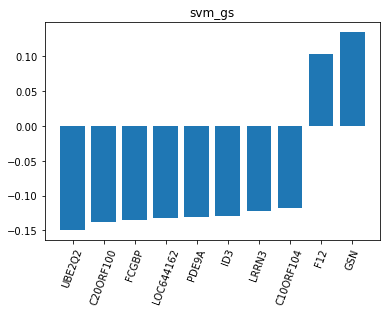

In [966]:
plot_genes(selected_gene_svm_gs_final, model='svm_grid_search')

### SVM with Baysian Optimisation of hyper parameter C


In [927]:
# Baysian optimisation with Gaussian processes for SVM hyper parameter optimisation

def train_svm_baysian(X_train, y_train):
    
    # define hyper paramaeter search space
    hyper_p_c = Real(1e-6, 100.0, 'log-uniform', name='C')
    search_space_svm = [hyper_p_c] 

    # define the objective function to optimise
    @use_named_args(search_space_svm)
    def evaluate_model(**params):
        cv_inner = LeaveOneOut()
        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # define the pipeline
            svc = SVC(kernel="linear", probability=True)  
            svc.set_params(**params)
            rfe = RFE(estimator=svc, n_features_to_select=20, step=20)
            svm_pipeline = Pipeline(steps=[('rfe', rfe),
                                           ('model', svc)])
            
            svm_pipeline.fit(X_train_inner, y_train_inner)

            y_val_pred = svm_pipeline.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        return 1.0 - score
    
    # perform gp optimization, and store best hyper parameters
    result = gp_minimize(evaluate_model, search_space_svm, n_calls=10)
    plot_convergence(result)
    #plot_evaluations(result)
    best_C = result.x[0]

    print('Best score: %.3f' % (1.0 - result.fun))
    print('Best C: %s' % (best_C))

    # retrain the model with selected hyper parameters
    clf = SVC(kernel="linear", C=best_C, probability=True)
    feature_elim = RFE(estimator=clf, n_features_to_select=20, step=20)
    model = Pipeline(steps=[('feature_elim', feature_elim),
                            ('clf', clf)])
    
    model.fit(X_train, y_train)

    return model, best_C

# nexted cross validation function for SVM

def nested_cv_svm_baysian(df, labels, n_repeats):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # implement univariate feature selection
        X_train, X_test = filter_features(X_train, y_train, X_test, 150)
        
        # train and fit the model
        model, best_C = train_svm_baysian(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        
        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append(best_C)
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, mis_classified_list

Best score: 1.000
Best C: 2.4354104292299774
Best score: 0.952
Best C: 0.06921800469221694
Best score: 0.976
Best C: 19.422305131608073
Best score: 1.000
Best C: 30.893173263252315
Best score: 0.976
Best C: 0.0033258348632466857
Best score: 0.976
Best C: 5.226442588063366
Best score: 0.976
Best C: 3.6890990368600414
Best score: 1.000
Best C: 0.0230257464326605
Best score: 0.976
Best C: 0.0012951299209768067
Best score: 1.000
Best C: 0.004260550292942044
Best score: 1.000
Best C: 18.18097673197362
Best score: 1.000
Best C: 0.0033320472866944562
Best score: 0.976
Best C: 0.060693622360224755
Best score: 1.000
Best C: 0.0024259732721393173
Best score: 1.000
Best C: 1.3514590884367368
Best score: 0.976
Best C: 0.03258413106819826
Best score: 1.000
Best C: 0.0024612767380152935
Best score: 1.000
Best C: 0.005180982067084756
The results for svm with all 63 examples:
[(0.9, 0.82, 1.0, 0.93), (1.0, 1.0, 1.0, 1.0), (0.9, 1.0, 0.85, 0.96), (0.9, 0.8, 1.0, 0.95), (1.0, 1.0, 1.0, 1.0), (0.95, 1.0,

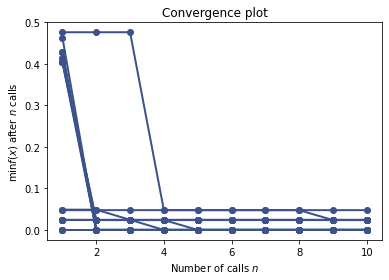

In [928]:
#scores_svm_red_b, best_parameters_svm_red_b, mis_classified_svm_red_b = nested_cv_svm_baysian(X_df_red, labels, 1)
scores_svm_b, best_parameters_svm_b, mis_classified_svm_b = nested_cv_svm_baysian(X_df, labels, 3)
scores_svm_no75_b, best_parameters_svm_no75_b, mis_classified_svm_no75_b = nested_cv_svm_baysian(X_df_no75, labels_no75, 3)

# print results
#print('The results for svm with test examples:')
#print(scores_svm_red_b)
#print(best_parameters_svm_red_b)
#print(np.mean(np.asarray(scores_svm_red_b), axis=0))
#print(mis_classified_svm_red_b)

print('The results for svm with all 63 examples:')
print(scores_svm_b)
print(best_parameters_svm_b)
print(np.mean(np.asarray(scores_svm_b), axis=0))
print(mis_classified_svm_b)

print('The results for svm without patient 75:')
print(scores_svm_no75_b)
print(best_parameters_svm_no75_b)
print(np.mean(np.asarray(scores_svm_no75_b), axis=0))
print(mis_classified_svm_no75_b)


In [929]:
# saving down results of the model
import pickle

with open('svm_results_b.pkl', 'wb') as f:
    pickle.dump([scores_svm_b, best_parameters_svm_b, mis_classified_svm_b], f)

with open('svm_results_no75_b.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b, best_parameters_svm_no75_b, mis_classified_svm_no75_b], f)
    
#with open('svm_results.pkl', 'rb') as f:
#    a, b, c, d, e, f, g, h = pickle.load(f)

Best score: 0.968
Best C: 0.004928959351501696


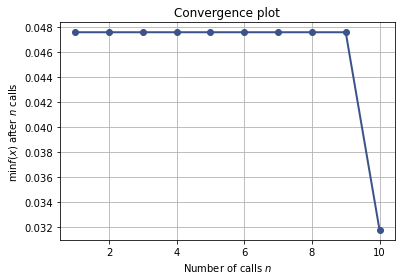

In [967]:
# re-training the final model on the full dataset to identify the selected features    

# filter the features of the entire dataset
X_df_filtered_svm_b, filtered_gene_codes_svm_b = filter_features_final(X_df, labels, 150)

# extract coefficients based on model type
final_svm_b, best_C_b = train_svm_baysian(X_df_filtered_svm_b, labels)


with open('svm_b_final_model.pkl', 'wb') as f:
    pickle.dump([X_df_filtered_svm_b, filtered_gene_codes_svm_b, final_svm_b, best_C_b], f)


In [969]:
# extract coefficients following RFE

selected_features_svm_b = final_svm_b.named_steps['feature_elim'].support_

selected_gene_list_svm_b = list(zip(filtered_gene_codes_svm_b, selected_features_svm_b))

selected_gene_codes_svm_b = []
for gene in selected_gene_list_svm_b:
    if gene[1] == True:
        selected_gene_codes_svm_b.append(gene[0])

# identify common gene codes
selected_gene_svm_b_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes_svm_b)].iloc[:, np.r_[14, 5]]
selected_gene_codes_common_svm_b = list(selected_gene_svm_b_df.iloc[:,1])

# coefficients of the selected features
selected_gene_coefficients_svm_b = final_svm_b.named_steps['clf'].coef_[0]
selected_gene_svm_b_df['Coefs'] = selected_gene_coefficients_svm_b
print(selected_gene_svm_b_df)
selected_gene_svm_b_final = list(zip(selected_gene_codes_common_svm_b, selected_gene_coefficients_svm_b))
selected_gene_svm_b_final = sorted(selected_gene_svm_b_final, key = lambda x: x[1])

print(selected_gene_svm_b_final)

           Probe_Id  ILMN_Gene     Coefs
1198   ILMN_1656378       NMT2 -0.071520
4301   ILMN_1674394    C20ORF3  0.060198
7305   ILMN_1747192     RNF125 -0.062098
9424   ILMN_1785095   ATP6V0E2 -0.062579
11732  ILMN_1683817     UBE2Q2 -0.074094
13543  ILMN_2321578     P2RY10 -0.066061
13839  ILMN_2082209  C20ORF100 -0.069784
15634  ILMN_1691402  LOC644162 -0.064424
20606  ILMN_1732296        ID3 -0.066444
22848  ILMN_1670130     ARID3A  0.061613
23051  ILMN_1685824    B4GALT5  0.059683
32423  ILMN_1660629     NBEAL2  0.066913
33119  ILMN_1801043        GSN  0.067132
34814  ILMN_2306540      PDE9A -0.073623
37399  ILMN_1770641      KLHL3 -0.062005
38198  ILMN_1738955  C10ORF104 -0.066527
39676  ILMN_2302757      FCGBP -0.075890
44671  ILMN_1671766        F12  0.058794
45858  ILMN_1653200   SLC22A17  0.070306
47762  ILMN_1773650      LRRN3 -0.063019
[('FCGBP', -0.07589037585758412), ('UBE2Q2', -0.07409380220762118), ('PDE9A', -0.07362338155575435), ('NMT2', -0.0715195815423605), ('C20OR

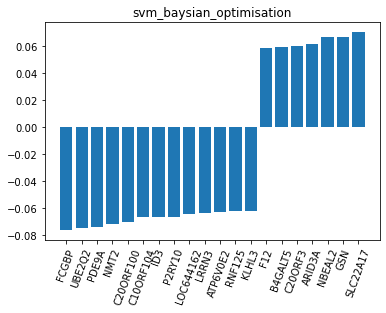

In [970]:
plot_genes(selected_gene_svm_b_final, model='svm_baysian_optimisation')

### Classifier 3: Random Forest

- Random Forest / Tree based models have intrinsic feature selection built in (read up)
- ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- ref: https://www.researchgate.net/profile/Shuzlina-Rahman/publication/322920304_Feature_selection_methods_Case_of_filter_and_wrapper_approaches_for_maximising_classification_accuracy/links/5eb17fa545851592d6b9b50c/Feature-selection-methods-Case-of-filter-and-wrapper-approaches-for-maximising-classification-accuracy.pdf?origin=publication_detail
- Improved by using full feature set and setting max_features for each tree - randomised search over number of estimators and the max features
- Ran model through the nested CV and averaged the results
- Extracted the feature importances from the resulting model, for comparison with other models

In [930]:
# Baysian optimisation with Gaussian processes for Random Forest hyper parameter optimisation
# define hyper paramaeter search space

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut
from skopt.space import Categorical, Real, Integer

def nested_cv_rf(df, labels, n_repeats):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # train and fit the model
        model, best_n_estimators, best_max_features = train_rf(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_C, best_f))
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, mis_classified_list


def train_rf(X_train, y_train):

    # define pipeline and perform search
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]  # originally this was num=20
    max_features = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
    param_grid = {'n_estimators': n_estimators,
                   'max_features': max_features
                   }
    
    cv_inner = loocv
    cv_res= []

    for param in ParameterGrid(param_grid):

        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # fit model
            rf_clf = RandomForestClassifier()
            rf_clf.fit(X_train_inner, y_train_inner)

            # predict validation set
            y_val_pred = rf_clf.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        print('Parameters:'+str(param)+'  Score:'+str(score))
        cv_res.append([param['n_estimators'], param['max_features'], score])

    cv_res = np.asarray(cv_res)    
    best_n_estimators = int(cv_res[np.argmax(cv_res[:,2])][0])
    best_max_features = int(cv_res[np.argmax(cv_res[:,2])][1])
    print('Best no. estimators:  '+str(best_n_estimators)+',   Best max features:  '+str(best_max_features))

    # retrain the model with optimum hyper parameters
    model = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features)        
    model.fit(X_train, y_train)

    return model, best_n_estimators, best_max_features


In [931]:
#scores_rf_red, best_parameters_rf_red, mis_classified_rf_red = nested_cv_rf(X_df_red, labels, 1)
scores_rf, best_parameters_rf, mis_classified_rf = nested_cv_rf(X_df, labels, 3)
scores_rf_no75, best_parameters_rf_no75, mis_classified_rf_no75 = nested_cv_rf(X_df_no75, labels_no75, 3)

#print results
#print('The results for random forest with test data:')
#print(scores_rf_red)
#print(best_parameters_rf_red)
#print(np.mean(np.asarray(scores_rf_red), axis=0))
#print(mis_classified_rf_red)

print('The results for rf with all 63 examples:')
print(scores_rf)
print(best_parameters_rf)
print(np.mean(np.asarray(scores_rf), axis=0))
print(mis_classified_rf)

print('The results for rf without patient 75:')
print(scores_rf_no75)
print(best_parameters_rf_no75)
print(np.mean(np.asarray(scores_rf_no75), axis=0))
print(mis_classified_rf_no75)


Parameters:{'max_features': 100, 'n_estimators': 100}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 550}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 775}  Score:0.9285714285714286
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.9285714285714286
Parameters:{'max_features': 325, 'n_estimators': 100}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 550}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 775}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 1000}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_estimators': 100}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_es

Parameters:{'max_features': 100, 'n_estimators': 100}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 325}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 550}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 775}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 325, 'n_estimators': 100}  Score:1.0
Parameters:{'max_features': 325, 'n_estimators': 325}  Score:1.0
Parameters:{'max_features': 325, 'n_estimators': 550}  Score:1.0
Parameters:{'max_features': 325, 'n_estimators': 775}  Score:1.0
Parameters:{'max_features': 325, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 550, 'n_estimators': 100}  Score:1.0
Parameters:{'max_features': 550, 'n_estimators': 325}  Score:1.0
Parameters:{'max_features': 550, 'n_estimators': 550}  Score:1.0
Parameters:{'max_features': 550, 'n_estimators': 775}  Score:1.0
Parameters:{'max_features': 550, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_featu

Parameters:{'max_features': 325, 'n_estimators': 1000}  Score:0.9285714285714286
Parameters:{'max_features': 550, 'n_estimators': 100}  Score:0.9285714285714286
Parameters:{'max_features': 550, 'n_estimators': 325}  Score:0.9285714285714286
Parameters:{'max_features': 550, 'n_estimators': 550}  Score:0.9285714285714286
Parameters:{'max_features': 550, 'n_estimators': 775}  Score:0.9285714285714286
Parameters:{'max_features': 550, 'n_estimators': 1000}  Score:0.9047619047619048
Parameters:{'max_features': 775, 'n_estimators': 100}  Score:0.9285714285714286
Parameters:{'max_features': 775, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 775, 'n_estimators': 550}  Score:0.9285714285714286
Parameters:{'max_features': 775, 'n_estimators': 775}  Score:0.9285714285714286
Parameters:{'max_features': 775, 'n_estimators': 1000}  Score:0.9047619047619048
Parameters:{'max_features': 1000, 'n_estimators': 100}  Score:0.9285714285714286
Parameters:{'max_features': 1000, 'n

Parameters:{'max_features': 550, 'n_estimators': 775}  Score:0.9512195121951219
Parameters:{'max_features': 550, 'n_estimators': 1000}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 100}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 325}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 550}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 775}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 1000}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 100}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 325}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 550}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 775}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 1000}  Score:0.9512195121951219
Best no. estimators:  100,   Bes

Parameters:{'max_features': 775, 'n_estimators': 775}  Score:0.9512195121951219
Parameters:{'max_features': 775, 'n_estimators': 1000}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 100}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 325}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 550}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 775}  Score:0.9512195121951219
Parameters:{'max_features': 1000, 'n_estimators': 1000}  Score:0.9512195121951219
Best no. estimators:  100,   Best max features:  100
Parameters:{'max_features': 100, 'n_estimators': 100}  Score:0.9761904761904762
Parameters:{'max_features': 100, 'n_estimators': 325}  Score:0.9761904761904762
Parameters:{'max_features': 100, 'n_estimators': 550}  Score:0.9761904761904762
Parameters:{'max_features': 100, 'n_estimators': 775}  Score:0.9761904761904762
Parameters:{'max_features': 100, 'n_estimators': 1000}  Scor

In [932]:
# re-training the final model on the full dataset to identify the selected features    
# extract coefficients based on model type

final_rf, best_n_estimators, best_max_features = train_rf(X_df, labels)


Parameters:{'max_features': 100, 'n_estimators': 100}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 550}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 775}  Score:0.9523809523809523
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 100}  Score:0.9365079365079365
Parameters:{'max_features': 325, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 550}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 775}  Score:0.9523809523809523
Parameters:{'max_features': 325, 'n_estimators': 1000}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_estimators': 100}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_estimators': 325}  Score:0.9523809523809523
Parameters:{'max_features': 550, 'n_es

The number of selected genes is:  251


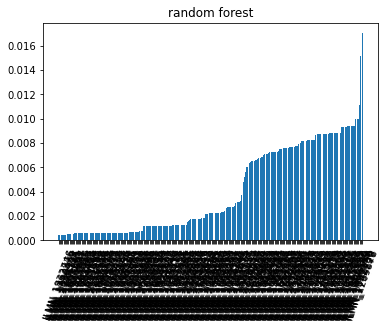

In [933]:
# identify genes and print
selected_features_rf = final_rf.feature_importances_
rf_genes, rf_gene_df = identify_genes(X_df, gene_df, selected_features_rf)
rf_gene_df
print('The number of selected genes is:  '+str(len(rf_genes)))
plot_genes(rf_genes, model='random forest')


In [993]:
# extract coefficients following RFE

selected_features_rf = final_rf.feature_importances_
selected_gene_list_rf = list(zip(X_df.columns, selected_features_rf))

selected_gene_codes_rf = []
selected_gene_coefficients_rf = []
for gene in selected_gene_list_rf:
    if gene[1] > 0:
        selected_gene_codes_rf.append(gene[0])
        selected_gene_coefficients_rf.append(gene[1])

# identify common gene codes
selected_gene_rf_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes_rf)].iloc[:, np.r_[14, 5]]
selected_gene_codes_common_rf = list(selected_gene_rf_df.iloc[:,1])

# zip features importances with common names

selected_gene_rf_final = list(zip(selected_gene_codes_common_rf, selected_gene_coefficients_rf))
selected_gene_rf_final = sorted(selected_gene_rf_final, key = lambda x: x[1])


251
251


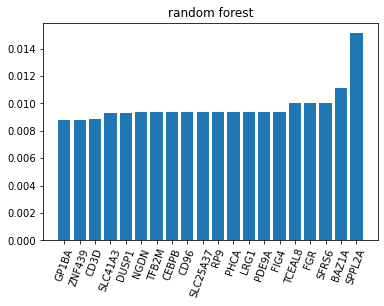

In [995]:
plot_genes(selected_gene_rf_final[-21:-1], model='random forest')

In [935]:
# save the variables

with open('rf_results.pkl', 'wb') as f:
    pickle.dump([scores_rf, best_parameters_rf, mis_classified_rf, selected_features_rf], f)

with open('rf_results_no75.pkl', 'wb') as f:
    pickle.dump([scores_rf_no75, best_parameters_rf_no75, mis_classified_rf_no75], f)

In [972]:
with open('rf_final_model.pkl', 'wb') as f:
    pickle.dump([final_rf, best_n_estimators, best_max_features], f)

### Gene Identification Summary

Using most important features output to identify the genes used by the classifiers

In [1004]:
def unzip(features):
    genes = [ i for i, j in features]
    return genes

lr_genes = unzip(selected_gene_lr_final[-21:-1])
svm_genes = unzip(selected_gene_svm_b_final)
rf_genes = unzip(selected_gene_rf_final[-21:-1])

intersection_list = []
intersection_list.extend(list(set(lr_genes).intersection(svm_genes)))
intersection_list.extend(list(set(lr_genes).intersection(rf_genes)))
intersection_list.extend(list(set(svm_genes).intersection(rf_genes)))

intersection_list

['PDE9A']

### Classifier 4: XGBoost

- Using the XGBoost library rather than sklearn, given more features available
- code credit: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
- code credit: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- Feature elimination with XGBoost- https://github.com/dhamvi01/Xgboost-Feature-Elimination/blob/master/Xgb-RFE.py

In [975]:
import xgboost as xgb

In [978]:
# nested cross validation function, customised to xgb

def nested_cv_xgb(df, labels, n_repeats):
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # train model
        model, best_max_depth, best_learning_rate, best_colsample_bytree = train_xgb(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        
        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_max_depth,best_learning_rate, best_colsample_bytree, best_f))
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, mis_classified_list


# function to train xgb model

def train_xgb(X_train, y_train):
      
    param_grid = {"max_depth": [3, 5],
                  "learning_rate": [0.3],
                  "colsample_bytree": [0.01, 0.1, 1]}
    cv_inner = loocv
    cv_res= []

    for param in ParameterGrid(param_grid):

        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # define the rfe proceedure
            xgb_clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss')       
            xgb_clf.fit(X_train_inner, y_train_inner)

            y_val_pred = xgb_clf.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        print('Parameters:'+str(param)+'  Score:'+str(score))
        cv_res.append([param['max_depth'], param['learning_rate'], param['colsample_bytree'], score])

    cv_res = np.asarray(cv_res)    
    best_max_depth = int(cv_res[np.argmax(cv_res[:,2])][0])
    best_learning_rate = cv_res[np.argmax(cv_res[:,2])][1]
    best_colsample_bytree = cv_res[np.argmax(cv_res[:,2])][2]
    print('Best max depth:  '+str(best_max_depth)+',   Best colsample:  '+str(best_colsample_bytree))

    # retrain the model with selected hyper parameters
    model = xgb.XGBClassifier(max_depth=best_max_depth,
                                learning_rate=best_learning_rate,
                                colsample_bytree=best_colsample_bytree,
                                objective="binary:logistic",
                                eval_metric='logloss')       

    model.fit(X_train, y_train)

    return model, best_max_depth, best_learning_rate, best_colsample_bytree


In [980]:
import warnings
warnings.filterwarnings("ignore")

scores_xgb_red, best_parameters_xgb_red, mis_classified_xgb_red = nested_cv_xgb(X_df_red, labels, 1)
scores_xgb, best_parameters_xgb, mis_classified_xgb = nested_cv_xgb(X_df, labels, 3)
scores_xgb_no75, best_parameters_xgb_no75, mis_classified_xgb_no75 = nested_cv_xgb(X_df_no75, labels, 3)

Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Best max depth:  3,   Best colsample:  1.0
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.1, 'learning_r

KeyboardInterrupt: 

In [979]:
# print results
#print('The results for xgb with all test data:')
#print(scores_xgb_red)
#print(best_parameters_xgb_red)
#print(np.mean(np.asarray(scores_xgb_red), axis=0))
#print(mis_classified_xgb_red)

print('The results for random forest with all 63 examples:')
print(scores_xgb)
print(best_parameters_xgb)
print(np.mean(np.asarray(scores_xgb), axis=0))
print(mis_classified_xgb)


print('The results for random forest without patient 75:')
print(scores_xgb_no75)
print(best_parameters_xgb_no75)
print(np.mean(np.asarray(scores_xgb_no75), axis=0))
print(mis_classified_xgb_no75)

Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Best max depth:  3,   Best colsample:  1.0
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.1, 'learning_r

In [ ]:
# retrain final model

final_xgb, best_max_depth, best_learning_rate, best_colsample_bytree = train_xgb(X_df, labels)

23


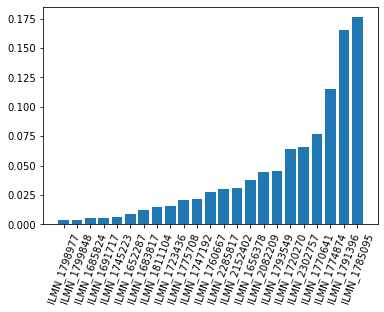

In [365]:
# extract the genes with non-zero coefficients in the model for comparison with other models

# identify genes and print
selected_features_xgb = final_xgb.feature_importances_
xgb_genes, xgb_gene_df = identify_genes(X_df, gene_df, selected_features_xgb)
xgb_gene_df
print('The number of selected genes is:  '+str(len(xgb_genes)))
plot_genes(xgb_genes, model='xgboost')

In [ ]:
# save the variables

with open('xgb_results.pkl', 'wb') as f:
    pickle.dump([scores_xgb, best_parameters_xgb, mis_classified_xgb], f)

with open('xgb_results_no75.pkl', 'wb') as f:
    pickle.dump([scores_xgb_no75, best_parameters_xgb_no75, mis_classified_xgb_no75], f)

In [ ]:
with open('xgb_final_model.pkl', 'wb') as f:
    pickle.dump([final_xgb, best_max_depth, best_learning_rate, best_colsample_bytree], f)

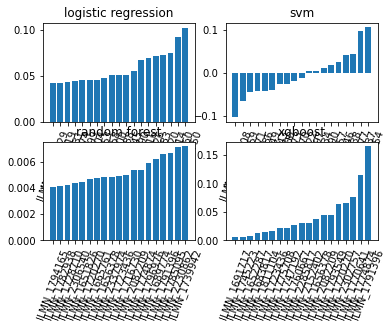

In [397]:
# plot with various axes scales
plt.figure()

# logistic regression
plt.subplot(221)
plot_genes(lr_features, model='logistic regression')

# svm
plt.subplot(222)
plot_genes(svm_features, model='svm')

# random forest
plt.subplot(223)
plot_genes(rf_features, model='random forest')

# xgboost
plt.subplot(224)
plot_genes(xgb_features, model='xgboost')

pyplot.show()


# IGNORE BELOW THIS LINE

In [413]:
def unzip(features):
    genes = [ i for i, j in features]
    return genes

lr_genes = unzip(lr_features)
svm_genes = unzip(svm_features)
rf_genes = unzip(rf_features)
xgb_genes = unzip(xgb_features)

In [415]:
# find the common names of the genes

gene_df[gene_df['Probe_Id'].isin(intersection_list)].iloc[:, np.r_[14, 5]]

,Probe_Id,ILMN_Gene
1198,ILMN_1656378,NMT2
10587,ILMN_1720270,CDR2
12973,ILMN_1791396,DGCR6
13839,ILMN_2082209,C20ORF100
29596,ILMN_1723436,PFKFB2
40968,ILMN_1774874,IL1RN


In [421]:
# x. feature selection based on genes in logistic regression with non-zero coefficient

X_gene_set = X_df.loc[:, intersection_list]

# define cross validation approach
cv_inner = LeaveOneOut()

# define hyper parameter search space to optimise
search_space = 20

# define the model / search
search = LogisticRegressionCV(Cs=search_space,
                              penalty='l1',
                              solver="liblinear",
                              cv=cv_inner,
                              scoring='accuracy',
                              refit=True)

# define methods to extract best hyper parameters and features from the model
name = 'lr'

# run nested cross validation
scores_lrgs, best_parameters_lrgs, selected_features_lrgs, mis_classified_lrgs = nested_cv(search,X_gene_set,labels,name,4)

# print results
print('The results for logistic regression with all 63 examples:')
print(scores_lrgs)
print(best_parameters_lrgs)
print(np.mean(np.asarray(scores_lrgs), axis=0))
print(mis_classified_lrgs)

The results for logistic regression with all 63 examples:
[(0.95, 1.0, 0.92, 0.99), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (0.9, 1.0, 0.83, 1.0), (1.0, 1.0, 1.0, 1.0), (0.95, 0.91, 1.0, 1.0), (0.95, 1.0, 0.92, 0.98), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (0.95, 1.0, 0.89, 0.98), (1.0, 1.0, 1.0, 1.0), (0.95, 1.0, 0.91, 1.0)]
[array([4.2813324]), array([0.08858668]), array([0.08858668]), array([0.08858668]), array([0.08858668]), array([1.62377674]), array([0.08858668]), array([0.08858668]), array([0.08858668]), array([0.08858668]), array([0.08858668]), array([0.08858668])]
[0.97083333 0.9925     0.95583333 0.99583333]
[{'Con_165a': 'fp'}, {}, {}, {'Con_040': 'fp'}, {}, {}, {'Con_165a': 'fp'}, {}, {}, {}, {}, {'Con_040': 'fp'}]


### Ensemble model code - maybe reuse

In [72]:
# fit model on dataset
def fit_model(model, X_train, y_train):
    model = model
    model.fit(X_train, y_train)
    return model

In [73]:
# function to generate predictions
def ensemble_predictions(models, X_test):
    # make predictions
    y_preds = [model.predict(X_test) for model in models]
    y_preds = np.array(y_preds)
    y_preds_probab = [model.predict_proba(X_test) for model in models]
    y_preds_probab = np.array(y_preds_probab)
    # average probability predictions across ensemble members
    y_preds_probab_avg = np.average(y_preds_probab, axis=0)
    # determine average class prediction across all models
    y_preds_avg = np.argmax(y_preds_probab_avg, axis=1)
    return y_preds_avg, y_preds_probab_avg


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut

# DOES THIS GIVE THE SAME SET OF PROBABILITIES EVERY ITERATION, I.E. NO STOCHASTIC ELEMETS TO THE LR MODEL?

# define the model
cv = LeaveOneOut()
log_reg_cv = LogisticRegressionCV(Cs=20, penalty='l1', solver="liblinear", cv=cv)

# train multiple models
n_models = 10
models = [fit_model(log_reg_cv, X_train, y_train) for i in range(n_models)]
print(models)

# predict
y_preds_lr, y_preds_probab_lr = ensemble_predictions(models, X_test)

# evaluate
print(score_model(y_preds_lr, y_preds_probab_lr, y_test))
print(mis_class_points(X_test, y_preds_lr, y_test))
plot_auc_cm(X_test, y_preds_lr, y_preds_probab_lr, y_test)

In [463]:
# testing for normailty using Shapiro Wilk

norm_dict = OrderedDict()
for column in column_names: #[0:5]:
    con_series = data_tpose3[column][0:35]
    shapiro_test = stats.shapiro(con_series)
    norm_dict[column] = shapiro_test.pvalue
    
#norm_dict

In [659]:
# x. feature selection based on genes in logistic regression with non-zero coefficient

gene_index = []
gene_index.append([val[0] for val in gene_coefs_sorted])
df_red1 = df.loc[:, gene_index[0]]


# create new features vector, and split

X_reduced = standardise(df_red1)
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_reduced, Y, test_size=0.4, random_state=1)

# SVM classifier

svm_clf=SVC(kernel="linear", random_state=1)
svm_clf.fit(X_red_train, y_train)
svm_clf.score(X_red_test, y_test)


,ILMN_1804148,ILMN_1733276,ILMN_1683817,ILMN_1691402,ILMN_1652650,ILMN_2400183,ILMN_2264011,ILMN_1717197,ILMN_1747192,ILMN_1659800,...,ILMN_2082209,ILMN_1786433,ILMN_2087989,ILMN_1775744,ILMN_1762071,ILMN_1677906,ILMN_1789642,ILMN_1660629,ILMN_1669281,ILMN_2363489
Con_001,9.2482,8.2974,8.9179,9.1453,8.2035,8.3242,10.8239,9.3468,7.9025,7.923,...,9.3405,7.7609,7.5719,8.7739,7.4165,10.3523,7.4165,7.8414,7.5438,8.0306
Con_017,9.1308,8.1693,9.1417,8.8694,8.007,8.1921,11.0308,9.5891,7.8209,7.293,...,9.1884,7.8326,7.7396,8.69,7.4233,10.4527,7.6051,7.9381,7.5823,8.0894
Con_021,9.0007,8.1167,9.154,8.2019,7.909,8.195,10.6904,9.6435,7.8912,7.2871,...,8.6219,7.7485,7.8544,8.1969,7.3221,9.2921,7.6426,8.1409,8.0705,8.2665
Con_022b,9.1283,7.9644,8.997,7.9236,7.9545,8.2893,11.2486,8.8398,7.8079,7.3722,...,9.6519,7.8024,7.8428,8.4029,7.4075,9.0954,7.6117,8.1839,8.0715,8.305
Con_028,9.3336,8.2082,9.0675,8.9659,7.8979,8.2616,11.1644,9.6249,7.9401,7.5242,...,9.61,8.0068,7.9339,8.8487,7.4443,10.3253,7.6561,7.9994,7.5062,8.1178


In [525]:
# to view entire dataframe

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(etc...)

In [ ]:
def std_split(examples, labels, split):
    imputer = SimpleImputer(strategy='median')
    examples_imputed = imputer.fit_transform(examples)
    scaler = StandardScaler()
    examples_scaled = scaler.fit_transform(examples_imputed)
    X_train, X_test, y_train, y_test = train_test_split(examples_scaled, labels, test_size=split, random_state=42)
    return X_train, X_test, y_train, y_test

Accuracy:  0.92
Recall:  0.94
Precision:  0.94
AUC:   0.98


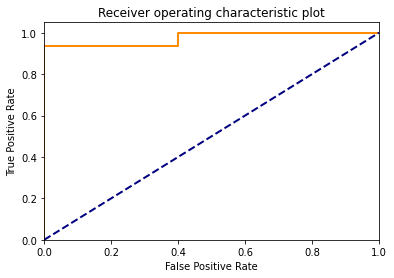

Patient Con_087a has been classified as  1 and should be  0
Patient Inf_149 has been classified as  0 and should be  1


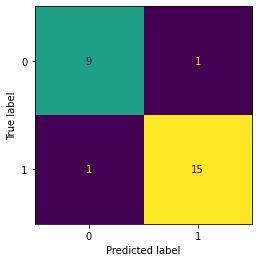

In [113]:
# Random Forest with Recursive Feature Elimination - NOT USED

from sklearn.ensemble import RandomForestClassifier

# train
rf_clf = RandomForestClassifier(random_state=1)
rf_selector = RFE(rf_clf, n_features_to_select=10, step=1)
rf_selector = rf_selector.fit(X_train_red, y_train)

# predict
y_pred_rf = rf_selector.predict(X_test_red)
y_pred_probab_rf = rf_selector.predict_proba(X_test_red)

# evaluate
model_analysis(rf_selector, X_test_red, y_pred_rf, y_pred_probab_rf, y_test)

Optimum L1 regularisation parameter: [1.]
(0.95, 0.89, 1.0, 1.0)
{'Inf_149': 'fn'}


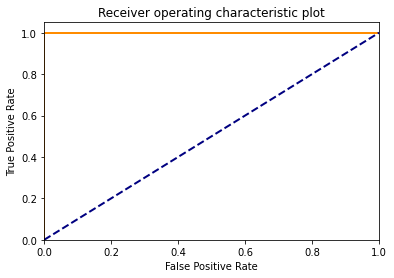

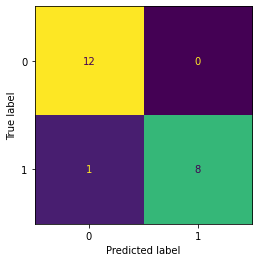

In [47]:
# initial logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut

# train
loocv = LeaveOneOut()
log_reg_cv = LogisticRegressionCV(Cs=5, penalty='l1', solver="liblinear", cv=loocv)
log_reg_cv.fit(X_train, y_train)
print('Optimum L1 regularisation parameter: '+str(log_reg_cv.C_))

# predict
y_pred_lr = log_reg_cv.predict(X_test)
y_pred_probab_lr = log_reg_cv.predict_proba(X_test)

# evaluate
print(score_model(y_pred_lr, y_pred_probab_lr, y_test))
print(mis_class_points(X_test, y_pred_lr, y_test))
plot_auc_cm(X_test, y_pred_lr, y_pred_probab_lr, y_test)

In [164]:
# random forest using a restricted set of features to reduce run time. Randomized search optimising the 
# balance between number of features used and number of estimators

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut
import time

start_time = time.time()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
max_features = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features
               }
print(random_grid)

rf_clf_2 = RandomForestClassifier(random_state=1)
loocv = LeaveOneOut()
rf_random = RandomizedSearchCV(estimator = rf_clf_2,
                               param_distributions = random_grid,
                               n_iter = 30,
                               refit=True,
                               cv = loocv)
rf_random.fit(X_train, y_train)

end_time = time.time()
print(f"The execution time is: {end_time-start_time}")

# capture feature importances
f_importance = rf_random.best_estimator_.feature_importances_

# save the model given running time
dump(rf_random, 'rf_random.joblib')


{'n_estimators': [100, 2000], 'max_features': [100, 1000]}
The execution time is: 265.78545570373535


RandomForestClassifier(max_features=1000, n_estimators=2000, random_state=1)

{'n_estimators': 1700, 'max_features': 800}
Accuracy:  0.96
Recall:  0.92
Precision:  1.0
AUC:   0.99


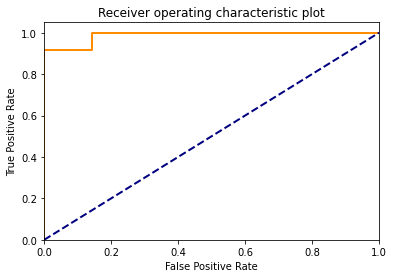

Patient Inf075 has been classified as  0 and should be  1


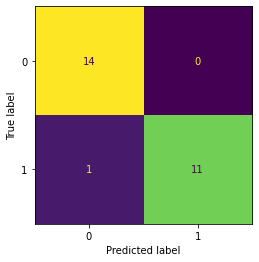

In [245]:
# load the saved model

rf_random = load('rf_random.joblib') 

# best parameters

print(rf_random.best_params_)

# predict
y_pred_rf2 = rf_random.predict(X_test)
y_pred_probab_rf2 = rf_random.predict_proba(X_test)

# evaluate
model_analysis(X_test, y_pred_rf2, y_pred_probab_rf2, y_test)

/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Accuracy: 0.952
Best Parameters: [0.389256965562435]


<AxesSubplot:xlabel='C', ylabel='Number of samples'>

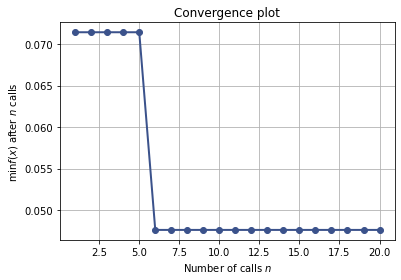

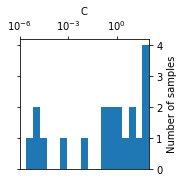

In [349]:
# Baysian search - single train / test evaluation - in case mess up

from skopt.space import Real, 
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.plots import plot_convergence, plot_evaluations

# define hyper paramaeter search space
hyper_p_c = Real(low=1e-6, high=100.0, prior='log-uniform', name='C')
search_space = [hyper_p_c]

# define the objective function to optimise over the hyper-parameter search space. Here we want to minimise 1- the 
# accuracy score - balancing recall and precision in the model.
@use_named_args(search_space)
def evaluate_model(**params):
    model = LogisticRegression(penalty='l1', solver="liblinear")
    model.set_params(**params)
    # define test harness
    cv = LeaveOneOut()
    # perform the search across the space of values of C
    result = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')
    # calculate the mean of the scores
    estimate = np.mean(result)
    # convert from a maximizing score to a minimizing score
    return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space, n_calls=20)

# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))
plot_convergence(result)
plot_evaluations(result)

In [191]:
# Initial feature selection using univariate method - not needed since a single train / test split

num_features = 500
fs=SelectKBest(mutual_info_classif, k=num_features).fit(X_train, y_train)
X_train_red = fs.transform(X_train)
X_test_red = fs.transform(X_test)

# Identify columns selected

gene_codes = df.columns
kbest_genes = fs.get_support()
gene_list = list(zip(gene_codes, kbest_genes))

gene_codes_reduced = []
for gene in gene_list:
    if gene[1] == True:
        gene_codes_reduced.append(gene[0])
        
print('The number of features selected:  '+str(len(gene_codes_reduced)))

# re-create DataFrame for X_train_red and X_test_red

X_train_red = pd.DataFrame(X_train_red, columns=gene_codes_reduced, index=X_train.index)
X_test_red = pd.DataFrame(X_test_red, columns=gene_codes_reduced, index=X_test.index)

X_test_red

The number of features selected:  500


,ILMN_1700306,ILMN_1778764,ILMN_1685312,ILMN_1911605,ILMN_2390859,ILMN_1663541,ILMN_2256359,ILMN_1656378,ILMN_1768480,ILMN_1739263,...,ILMN_1751789,ILMN_1773650,ILMN_2261784,ILMN_1660579,ILMN_1714599,ILMN_2258816,ILMN_1728298,ILMN_1739942,ILMN_1663685,ILMN_1800626
Con_062,0.833159,0.530819,-0.883253,1.880315,-0.885841,0.587572,1.476044,1.337178,1.213141,0.865492,...,0.507167,1.415266,1.365689,1.033457,0.862104,0.975359,1.161059,1.740120,1.040935,1.440165
Inf_203,-1.138958,-1.431796,0.977688,0.310028,0.630259,-1.190553,-0.966087,-1.187578,-1.343629,-1.239142,...,-0.495373,-1.145397,-1.127541,-0.778819,-0.907497,-1.517978,-0.965967,-1.269618,-1.095984,-1.391392
Inf_159a,-1.826881,-1.623699,1.951862,-2.238301,0.959611,-2.610249,-1.494750,-1.693020,-1.401972,-1.195336,...,-0.784046,-0.891666,-2.419558,0.500354,-1.288575,-1.453390,-1.962339,-1.483861,-2.060785,-2.535981
Con_042,1.155919,0.969799,-0.544900,1.331429,-1.194380,0.982043,1.305330,1.154954,0.251521,1.056739,...,1.704550,0.502944,0.898845,1.613403,1.939928,0.964149,0.813502,0.973268,1.594495,0.409223
Con_028,0.847183,0.319325,-0.335310,1.038756,-1.015924,1.347279,1.072938,1.139384,1.278004,0.973969,...,1.423061,0.209977,0.725178,1.757362,1.253603,0.653349,0.745570,0.657743,1.654465,0.085419
Inf_119,-0.158531,-0.721352,0.396222,-0.571934,-0.093776,-1.171730,-0.720111,-0.270114,-0.722111,0.214286,...,1.149181,-0.429602,-0.099994,-0.919806,-0.031674,-0.128521,-0.347170,-0.145385,-0.670788,0.486191
Con_022b,1.013476,0.601984,-0.978493,0.106044,-0.345849,1.362898,0.770793,0.846441,1.260501,0.594127,...,1.158479,0.967786,1.246382,0.554738,0.931362,0.944799,0.871833,0.552016,0.481969,0.818714
Con_069,0.651738,-0.365131,0.024660,0.440598,-1.045217,0.760178,1.687877,0.650666,0.845240,0.913679,...,1.070989,0.357893,1.122800,1.597408,0.810802,0.462653,0.307964,0.674279,1.147800,-0.228764
Inf_111,-1.191187,-1.732045,1.610690,-1.311994,0.971560,-0.560199,-0.917626,-0.961816,-0.279395,-1.724002,...,-1.369847,-1.320309,-1.874736,-0.854911,-1.316952,-1.369318,-1.324462,-1.359635,-1.552989,-1.484595
Inf_152,-1.888164,-0.403512,1.230356,-0.460088,0.187782,-0.766045,-0.695147,-1.533285,-0.363477,-0.502975,...,-0.062573,-2.133933,-0.519198,-0.829318,-0.616197,-1.791146,-1.860016,-1.382372,-0.763195,-0.961758


In [299]:
import xgboost as xgb

# pre-processing to xgb data format

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth': max_depth,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': colsample_bytree,
    'eval_metric': 'auc',
    # Other parameters
    'objective':'binary:logistic',
}

gridsearch_params = [
    (max_depth, colsample_bytree)
    for max_depth in [3] #, 5, 7]
    for colsample_bytree in [0.01] #, 0.1, 1]
]

# total number of boosting rounds, but limited by the early stopping rounds
num_boost_round = 100

# Define initial best params and MAE
max_auc = 0
best_params = None
for max_depth, colsample_bytree in gridsearch_params:
    print("CV with max_depth={}, colsample_bytree={}".format(max_depth, colsample_bytree))
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
        )
    
    print(cv_results)
    
    # Update best results
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, colsample_bytree)

print(max_auc)
print(best_params)

# for training on the test set later
#xgb_clf = xgb.train(
 #   params,
  #  dtrain,
   # num_boost_round=num_boost_round,
   # evals=[(dtest, "Test")],
   # early_stopping_rounds=10
#)

CV with max_depth=3, colsample_bytree=0.01
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.96500       0.017795       0.950000      0.100000
1         0.99852       0.001209       0.950000      0.100000
2         1.00000       0.000000       0.950000      0.100000
3         1.00000       0.000000       0.983333      0.033333
4         1.00000       0.000000       0.991667      0.016667
5         1.00000       0.000000       1.000000      0.000000
	AUC 1.0 for 5 rounds
1.0
(3, 0.01)


In [308]:
# training final model with best hyper parameters

best_params = {
    'max_depth': 3,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 0.1,
    'max_depth':2,
    'eval_metric': 'auc',
    'objective':'binary:logistic',
}

# for training on the test set later
xgb_clf = xgb.train(
    best_params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
    )

# train again with num boost rounds set
num_boost_round = xgb_clf.best_iteration + 1

xgb_clf = xgb.train(
    best_params,
    dtrain,
    num_boost_round=5,
    evals=[(dtest, "Test")]
    )


y_pred_probab_xgb = xgb_clf.predict(dtest)
y_pred_xgb = [round(value) for value in y_pred_probab_xgb]
print(y_pred_probab_xgb)
print(y_pred_xgb)
#plt.figure(figsize=(20,15))
#xgb.plot_importance(xgb_clf, ax=plt.gca())


[0]	Test-auc:1.00000
[0]	Test-auc:1.00000
[1]	Test-auc:1.00000
[2]	Test-auc:1.00000
[3]	Test-auc:1.00000
[4]	Test-auc:1.00000
[0.14142823 0.84146446 0.84146446 0.14142823 0.14142823 0.75781757
 0.14142823 0.14142823 0.84146446 0.84146446 0.14142823 0.14142823
 0.63659555 0.84146446 0.74819934 0.84146446 0.74819934 0.14142823
 0.34767017 0.7356338  0.21839157 0.14142823 0.84146446 0.74819934
 0.84146446 0.14142823]
[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]


In [311]:
accuracy = round(accuracy_score(y_test, y_pred_xgb),2)
recall = round(recall_score(y_test, y_pred_xgb),2)
precision = round(precision_score(y_test, y_pred_xgb),2) 
auc = round(roc_auc_score(y_test, y_pred_probab_xgb),2)
print(accuracy, recall, precision, auc)

1.0 1.0 1.0 1.0


In [ ]:
def nested_cv_svm_baysian(df, labels, n_repeats):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    selected_features_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # define pipeline and perform search
        hyper_p_c = Real(1e-6, 100.0, 'log-uniform', name='C')
        search_space_svm = [hyper_p_c] 
        
        @use_named_args(search_space_svm)
        def evaluate_model(**params):
            cv_inner = LeaveOneOut()
            y_val_classes = []
            y_val_predictions = []
            for train_index, val_index in cv_inner.split(X_train):

                X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
                y_train_inner, y_val = y_train[train_index], y_train[val_index]                

                # define the rfe proceedure
                svc = SVC(kernel="linear", probability=True)  
                svc.set_params(**params)
                rfe = RFE(estimator=svc, n_features_to_select=20, step=10)
                rfe.fit(X_train_inner, y_train_inner)
                
                y_val_pred = rfe.predict(X_val)
                y_val_classes.append(y_val)
                y_val_predictions.append(y_val_pred)
                
            score = roc_auc_score(y_val_classes, y_val_predictions)
            return 1.0 - score

        # perform optimization
        result = gp_minimize(evaluate_model, search_space_svm, n_calls=10)
        plot_convergence(result)
        #plot_evaluations(result)
        best_C = result.x[0]
        #best_f = int(cv_res[np.argmax(cv_res[:,2])][1])

        print('Best score: %.3f' % (1.0 - result.fun))
        print('Best C: %s' % (best_C))
           
        # retrain the model with selected hyper parameters
        clf = SVC(kernel="linear", C=best_C, probability=True)        
        feature_elim = RFE(estimator=clf, n_features_to_select=20, step=10)
        clf_2 = SVC(kernel="linear", C=best_C, probability=True) 
        model = Pipeline(steps=[('feature_elim', feature_elim),
                               ('clf_2', clf_2)])
        model.fit(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        
        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append(best_C)
        selected_features_list.append(selected_features)
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, selected_features_list, mis_classified_list


# support vector machine nested cross validation. The inner loop is a manual grid search over hyper parameters
# C and the number of features to select in the RFE

def nested_cv_svm(df, labels, n_repeats):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    selected_features_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # define pipeline and perform search
        param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10, 100], 'f': [5, 10, 20]}
        cv_inner = loocv

        cv_res= []
       
        for param in ParameterGrid(param_grid):

            y_val_classes = []
            y_val_predictions = []
            for train_index, val_index in cv_inner.split(X_train):

                X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
                y_train_inner, y_val = y_train[train_index], y_train[val_index]                

                # define the rfe proceedure
                svc = SVC(kernel="linear", C=param['C'], probability=True)        
                rfe = RFE(estimator=svc, n_features_to_select=param['f'], step=10)
                rfe.fit(X_train_inner, y_train_inner)
                
                y_val_pred = rfe.predict(X_val)
                y_val_classes.append(y_val)
                y_val_predictions.append(y_val_pred)
                
            
            score = accuracy_score(y_val_classes, y_val_predictions)
            print('Parameters:'+str(param)+'  Score:'+str(score))
            cv_res.append([param['C'], param['f'], score])
        
        cv_res = np.asarray(cv_res)    
        best_C = cv_res[np.argmax(cv_res[:,2])][0]
        best_f = int(cv_res[np.argmax(cv_res[:,2])][1])
        print('Best C:  '+str(best_C)+',   Best f:  '+str(best_f))

        # retrain the model with selected hyper parameters
        clf = SVC(kernel="linear", C=best_C, probability=True)        
        feature_elim = RFE(estimator=clf, n_features_to_select=best_f, step=10)
        clf_2 = SVC(kernel="linear", C=best_C, probability=True) 
        model = Pipeline(steps=[('feature_elim', feature_elim),
                               ('clf_2', clf_2)])
        model.fit(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        
        # extract coefficients based on model type                        
        selected_features = model.named_steps['clf_2'].coef_
        
        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_C, best_f))
        selected_features_list.append(selected_features)
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, selected_features_list, mis_classified_list


# IF NEEDED, MAY NEED TO REINSTATE THE SELECT K BEST APPROACH TO INITIALLY REDUCE THE NUMBER OF FEATURES
#fs=SelectKBest(mutual_info_classif, k=500)
#rfe = RFE(estimator=SVC(kernel="linear", probability=True, C=1.0), n_features_to_select=20, step=20)
#model = SVC(kernel="linear", probability=True, C=1.0)
#svm_pipeline = Pipeline(steps=[('kbest', fs), ('rfe', rfe),('model', model)])

In [248]:
# random forest using the nested CV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]  # originally this was num=20
max_features = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features
               }

rf_clf = RandomForestClassifier()
loocv = LeaveOneOut()

rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 5,  # need to increase to say 30
                               refit=True,
                               cv = loocv)
name = 'rf'

# run nested cross validation
scores_rf, best_parameters_rf, selected_features_rf, mis_classified_rf = nested_cv(rf_search, X_df, labels, name)
scores_rf_no75, best_parameters_rf_no75, selected_features_rf_no75, mis_classified_rf_no75 = nested_cv(rf_search,
                                                                                                       df_no75, 
                                                                                                       labels_no75,
                                                                                                       name)


print('The results for random forest with all 63 examples:')
print(scores_list_rf)
print(best_parameters_list_rf)
print(np.mean(np.asarray(scores_list_rf), axis=0))
print(mis_classified_list_rf)

print('The results for random forest without patient 75:')
print(scores_rf_no75)
print(best_parameters_rf_no75)
print(np.mean(np.asarray(scores_rf_no75), axis=0))
print(mis_classified_rf_no75)


The results for random forest with all 63 examples:
[(0.9, 0.8, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0), (0.95, 1.0, 0.9, 1.0)]
[{'n_estimators': 1155, 'max_features': 300}, {'n_estimators': 522, 'max_features': 200}, {'n_estimators': 733, 'max_features': 500}]
[0.95       0.93333333 0.96666667 1.        ]
[{'Inf075': 'fn', 'Inf_149': 'fn'}, {}, {'Con_165a': 'fp'}]
The results for random forest without patient 75:
[(1.0, 1.0, 1.0, 1.0), (0.95, 1.0, 0.91, 1.0), (0.95, 0.89, 1.0, 0.98)]
[{'n_estimators': 1155, 'max_features': 700}, {'n_estimators': 2000, 'max_features': 700}, {'n_estimators': 100, 'max_features': 300}]
[0.96666667 0.96333333 0.97       0.99333333]
[{}, {'Con_165a': 'fp'}, {'Inf_149': 'fn'}]
